Import libraries

In [1]:
import calendar
import csv
import json
import math
import numpy as np
import os.path
import pandas as pd
import re
from datetime import date, datetime, timedelta
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import colors
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from netCDF4 import Dataset

Read in TOAR airborne model da

In [2]:
# Number of days since 1900-01-01
days_since_1900 = 44074.725000

# Specify the base date
base_date = datetime(1900, 1, 1)

# Calculate the target date
target_date = base_date + timedelta(days=days_since_1900)

def process_model_output_files(directory_path):
    # List all NetCDF files in the directory containing "zlin_stash34001" in their names
    file_list = [f for f in os.listdir(directory_path) if f.endswith(".nc") and "zlin_stash34001" in f]

    # Initialize an empty list to store DataFrames
    dfs = []

    # Iterate through the filtered files
    for file_name in file_list:
        file_path = os.path.join(directory_path, file_name)
        with Dataset(file_path, 'r') as nc_file:
            data = {}  # Create an empty dictionary to store variable data

            # Define the variables you want and add them to the dictionary
            variable_list = ['time', 'latitude', 'longitude', 'altitude', 'region', 'm01s34i001']

            for variable in variable_list:
                data[variable] = nc_file.variables[variable][:]

        # Create a DataFrame for the current file
        df = pd.DataFrame(data)
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    model_data = pd.concat(dfs, ignore_index=True)

    # Convert O3 model data to ppbv
    cfactor = 1.e9 / 1.657
    model_data = model_data.rename(columns={'m01s34i001': 'ozone'})
    model_data['ozone'] = model_data['ozone'] * cfactor

    # Sort the DataFrame by the 'time' column in ascending order
    model_data = model_data.sort_values(by='time', ascending=True)
    
    return model_data

# Specify the directory path
directory_path = "/scratch/ajp255/homes/mrr32/home/data/PartIII_23/Model_Output"

# Call the function to process files in the specified directory
mod_flight = process_model_output_files(directory_path)

# Display the resulting DataFrame
mod_flight

,time,latitude,longitude,altitude,region,ozone
101123,31866.597222,36.224499,284.554993,4150.000000,TOAR_airborne,59.611256
101124,31866.597917,36.192570,284.576294,4160.000000,TOAR_airborne,59.788742
101125,31866.599306,36.144375,284.606750,4154.285645,TOAR_airborne,59.888271
101126,31866.600000,36.096142,284.636993,4154.285645,TOAR_airborne,60.063644
101127,31866.600694,36.044144,284.669586,4151.428711,TOAR_airborne,60.237450
...,...,...,...,...,...,...
312943,44102.766667,37.078949,283.985413,776.516174,TOAR_airborne,50.407895
312944,44102.767361,37.097878,283.922241,571.098328,TOAR_airborne,50.247582
312945,44102.768056,37.114399,283.862152,471.111603,TOAR_airborne,50.078013
312946,44102.768750,37.124432,283.804779,434.136505,TOAR_airborne,49.904518


Read in TOAR airborne observation data

In [3]:
# Data only starts from row 62 (headers on row 61)
skip_rows = 60 

# Define the path to the CSV file
file_path = '/home/ajp255/nethome/Data/PartIII_23/toar2_oceans_airborne_data_5000m_v0_91r.csv'

#The low_memory=False component removes NaN values
obs_flight = pd.read_csv(file_path,low_memory=False, skiprows=skip_rows)

# Rename columns and select desired variables
column_name_mapping = {
    'time_UTC[yyyy/m/d h:mm:ss]': 'time',
    'lat[deg]': 'latitude',
    'lon2[0-360degE]': 'longitude',
    'alt[m]': 'altitude', 
    'Ozone[ppbv]': 'ozone'
}

obs_flight = obs_flight.rename(columns=column_name_mapping)

selected_columns = ['time', 'latitude', 'longitude', 'altitude', 'ozone']
obs_flight = obs_flight[selected_columns]

# Define a function to convert the time column into same time format as model data
def convert_to_unix_timestamp(date_string):
    # Define the date format
    date_format = "%Y/%m/%d %H:%M"
    
    # Convert the date string to a datetime object
    datetime_obj = datetime.strptime(date_string, date_format)
    
    # Set the base date to January 1, 1900
    base_date = datetime(1900, 1, 1)
    
    # Calculate the difference in days
    delta_days = (datetime_obj - base_date).total_seconds() / (24 * 60 * 60)

    return delta_days

obs_flight['time'] = obs_flight['time'].apply(convert_to_unix_timestamp)

# Sort the DataFrame by the 'time' column in ascending order
obs_flight = obs_flight.sort_values(by='time', ascending=True)

# Sort the DataFrame by the 'time' column in ascending order from 1986 (when the model starts)
first_model_date = 31866
last_model_date = 44103	
obs_flight = obs_flight[(obs_flight['time'] >= first_model_date) & (obs_flight['time'] <= last_model_date)]
obs_flight = obs_flight.sort_values(by='time', ascending=True)

obs_flight

,time,latitude,longitude,altitude,ozone
0,31866.638889,36.224500,284.555000,4150.000000,45.300000
1,31866.639583,36.192571,284.576286,4160.000000,44.914286
2,31866.640972,36.144375,284.606750,4154.285714,44.914286
3,31866.641667,36.096143,284.637000,4154.285714,45.900000
4,31866.642361,36.044143,284.669571,4151.428571,48.371429
...,...,...,...,...,...
377617,44102.808333,37.078948,283.985402,776.516200,35.596700
377618,44102.809028,37.097879,283.922241,571.098300,35.286700
377619,44102.809722,37.114400,283.862149,471.111600,34.553300
377620,44102.810417,37.124433,283.804783,434.136500,33.783300


Merge model and observation data

In [4]:
# Reset indices to ensure alignment
mod_flight_reset = mod_flight.reset_index(drop=True)
obs_flight_reset = obs_flight.reset_index(drop=True)

# Create merge_df
merge_df = pd.DataFrame()

# Copy time, latitude, and longitude columns from mod_flight to merge_df
merge_df['time'] = mod_flight_reset['time'].copy()
merge_df['latitude'] = mod_flight_reset['latitude'].copy()
merge_df['longitude'] = mod_flight_reset['longitude'].copy()
merge_df['mod_ozone'] = mod_flight_reset['ozone'].copy()
merge_df['obs_ozone'] = obs_flight_reset['ozone'].copy()
merge_df['altitude'] = mod_flight_reset['altitude'].copy()

# Calculate ozone_mergeerence as mod_flight['ozone'] - obs_flight['ozone']
merge_df['ozone_difference'] = mod_flight_reset['ozone'] - obs_flight_reset['ozone']

# Drop rows where either "mod_ozone" or "obs_ozone" is NaN and obs is <2
merge_df = merge_df.dropna(subset=['mod_ozone', 'obs_ozone'])
merge_df = merge_df.drop(merge_df[merge_df['obs_ozone'] < 3].index)
merge_df['datetime'] = pd.to_datetime(merge_df['time'], origin='1900-01-01', unit='D')

# Display the mergeing DataFrame
merge_df

,time,latitude,longitude,mod_ozone,obs_ozone,altitude,ozone_difference,datetime
0,31866.597222,36.224499,284.554993,59.611256,45.300000,4150.000000,14.311256,1987-04-01 14:20:00.000000032
1,31866.597917,36.192570,284.576294,59.788742,44.914286,4160.000000,14.874456,1987-04-01 14:20:59.999999916
2,31866.599306,36.144375,284.606750,59.888271,44.914286,4154.285645,14.973985,1987-04-01 14:22:59.999999995
3,31866.600000,36.096142,284.636993,60.063644,45.900000,4154.285645,14.163644,1987-04-01 14:23:59.999999870
4,31866.600694,36.044144,284.669586,60.237450,48.371429,4151.428711,11.866021,1987-04-01 14:25:00.000000073
...,...,...,...,...,...,...,...,...
396504,44102.766667,37.078949,283.985413,50.407895,35.596700,776.516174,14.811195,2020-09-30 18:23:59.999999665
396505,44102.767361,37.097878,283.922241,50.247582,35.286700,571.098328,14.960882,2020-09-30 18:24:59.999999860
396506,44102.768056,37.114399,283.862152,50.078013,34.553300,471.111603,15.524713,2020-09-30 18:26:00.000000055
396507,44102.768750,37.124432,283.804779,49.904518,33.783300,434.136505,16.121218,2020-09-30 18:27:00.000000250


Airborne observation data global distribution

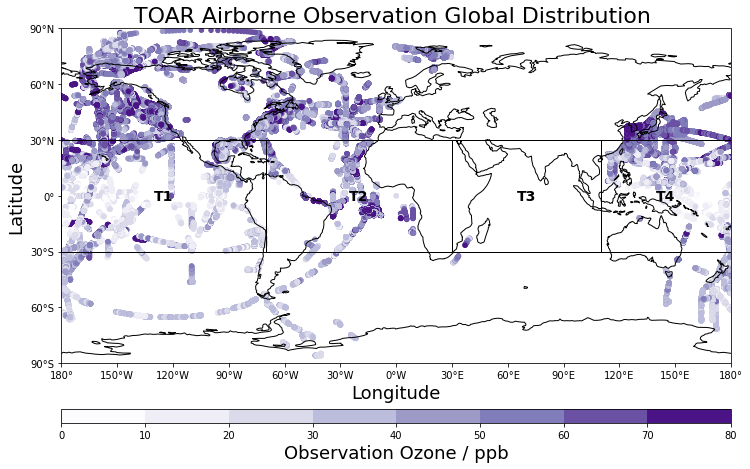

In [5]:
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Define the longitude bands
longitude_bands = {
    'T1': (180, 290),
    'T2': (290, 390),
    'T3': (30, 110),
    'T4': (110, 180),
}

def plot_observation(df, title, colorbar_label, filename, custom_colors=None, vmin=None, vmax=None, num_colors=10):
    # Extract data from the DataFrame
    latitude = df['latitude']
    longitude = df['longitude']
    obs_ozone = df['ozone'].dropna()

    # Create a custom colormap
    cmap = colors.ListedColormap(custom_colors) if custom_colors else plt.cm.get_cmap('coolwarm', num_colors)

    # Set the normalization bounds
    vmin = vmin if vmin is not None else obs_ozone.min()
    vmax = vmax if vmax is not None else obs_ozone.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Create a scatter plot
    fig = plt.figure(figsize=(12, 17))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
    ax1.add_feature(cartopy.feature.COASTLINE)

    # Scatter plot with colormap
    sc = ax1.scatter(longitude, latitude, c=obs_ozone, cmap=cmap,
                     norm=norm, s=20, transform=ccrs.PlateCarree())

    # Add discrete colorbar at the bottom
    bounds = np.linspace(vmin, vmax, num_colors + 1)
    cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', ticks=bounds, pad=0.05, aspect=50)
    cbar.set_label(colorbar_label, fontsize=18)

    # Set title and labels
    ax1.set_title(title, fontsize=22)
    ax1.set_xlabel('Longitude', fontsize=18)
    ax1.set_ylabel('Latitude', fontsize=18)

    # Add gridlines and labels
    ax1.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    # Add black boxes for the longitude bands
    for band, (lon_min, lon_max) in longitude_bands.items():
        rectangle = Rectangle((lon_min, -30), lon_max - lon_min, 60, transform=ccrs.PlateCarree(), 
                              edgecolor='black', facecolor='none')
        ax1.add_patch(rectangle)
        # Calculate the center of the rectangle for placing text
        center_lon = lon_min + (lon_max - lon_min) / 2
        ax1.text(center_lon, 0, band, transform=ccrs.PlateCarree(), 
                 horizontalalignment='center', verticalalignment='center', fontsize=14, color='black', weight='bold')

    # Save the plot
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# Example usage with custom color scale
custom_colors = ['#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#4a1486']
plot_observation(obs_flight, 'TOAR Airborne Observation Global Distribution ',
                'Observation Ozone / ppb', 'toar_airborne_observation_ozone.png',
                custom_colors=custom_colors, vmin=0, vmax=80, num_colors=8)

Global distribution of ozone bias (model-observation)

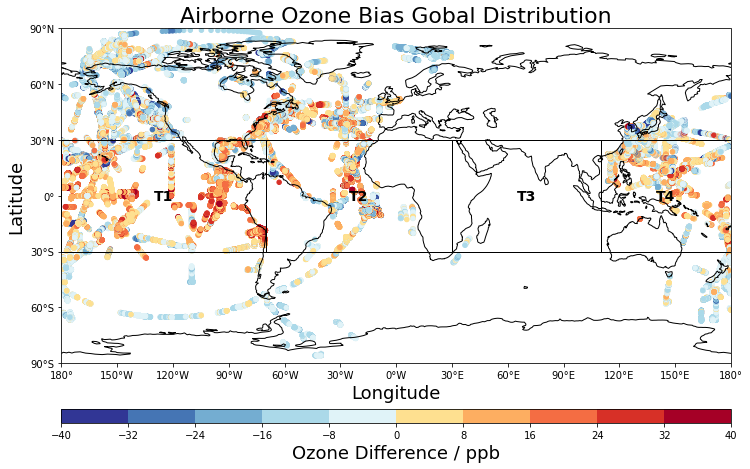

In [6]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

def plot_difference(df, title, colorbar_label, filename, custom_colors=None, vmin=None, vmax=None, num_colors=10):
    # Extract data from the DataFrame
    latitude = df['latitude']
    longitude = df['longitude']
    ozone_difference = df['ozone_difference'].dropna()

    # Create a custom colormap
    cmap = colors.ListedColormap(custom_colors) if custom_colors else plt.cm.get_cmap('coolwarm', num_colors)

    # Set the normalization bounds
    vmin = vmin if vmin is not None else ozone_difference.min()
    vmax = vmax if vmax is not None else ozone_difference.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Create a scatter plot
    fig = plt.figure(figsize=(12, 17))
    ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax1.add_feature(cartopy.feature.COASTLINE)

    # Scatter plot with colormap
    sc = ax1.scatter(longitude, latitude, c=ozone_difference, cmap=cmap,
                    norm=norm, s=20, transform=ccrs.PlateCarree())

    # Add discrete colorbar at the bottom
    bounds = np.linspace(vmin, vmax, num_colors + 1)
    cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', ticks=bounds, pad=0.05, aspect=50)
    cbar.set_label(colorbar_label, fontsize=18)

    # Set title and labels
    ax1.set_title(title, fontsize=22)
    ax1.set_xlabel('Longitude', fontsize=18)
    ax1.set_ylabel('Latitude', fontsize=18)

    # Add gridlines and labels
    ax1.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    # Add black boxes and names for the longitude bands
    for band, (lon_min, lon_max) in longitude_bands.items():
        rectangle = Rectangle((lon_min, -30), lon_max - lon_min, 60, transform=ccrs.PlateCarree(), 
                              edgecolor='black', facecolor='none')
        ax1.add_patch(rectangle)
        # Calculate the center of the rectangle for placing text
        center_lon = lon_min + (lon_max - lon_min) / 2
        ax1.text(center_lon, 0, band, transform=ccrs.PlateCarree(), 
                 horizontalalignment='center', verticalalignment='center', fontsize=14, color='black', weight='bold')
    
    # Save the plot
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# Example usage with custom color scale
custom_colors = ['#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8', '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
plot_difference(merge_df, 'Airborne Ozone Bias Gobal Distribution',
                'Ozone Difference / ppb', 'toar_airborne_ozone_difference.png',
                custom_colors=custom_colors, vmin=-40, vmax=40, num_colors=10)

Latitude band histograms

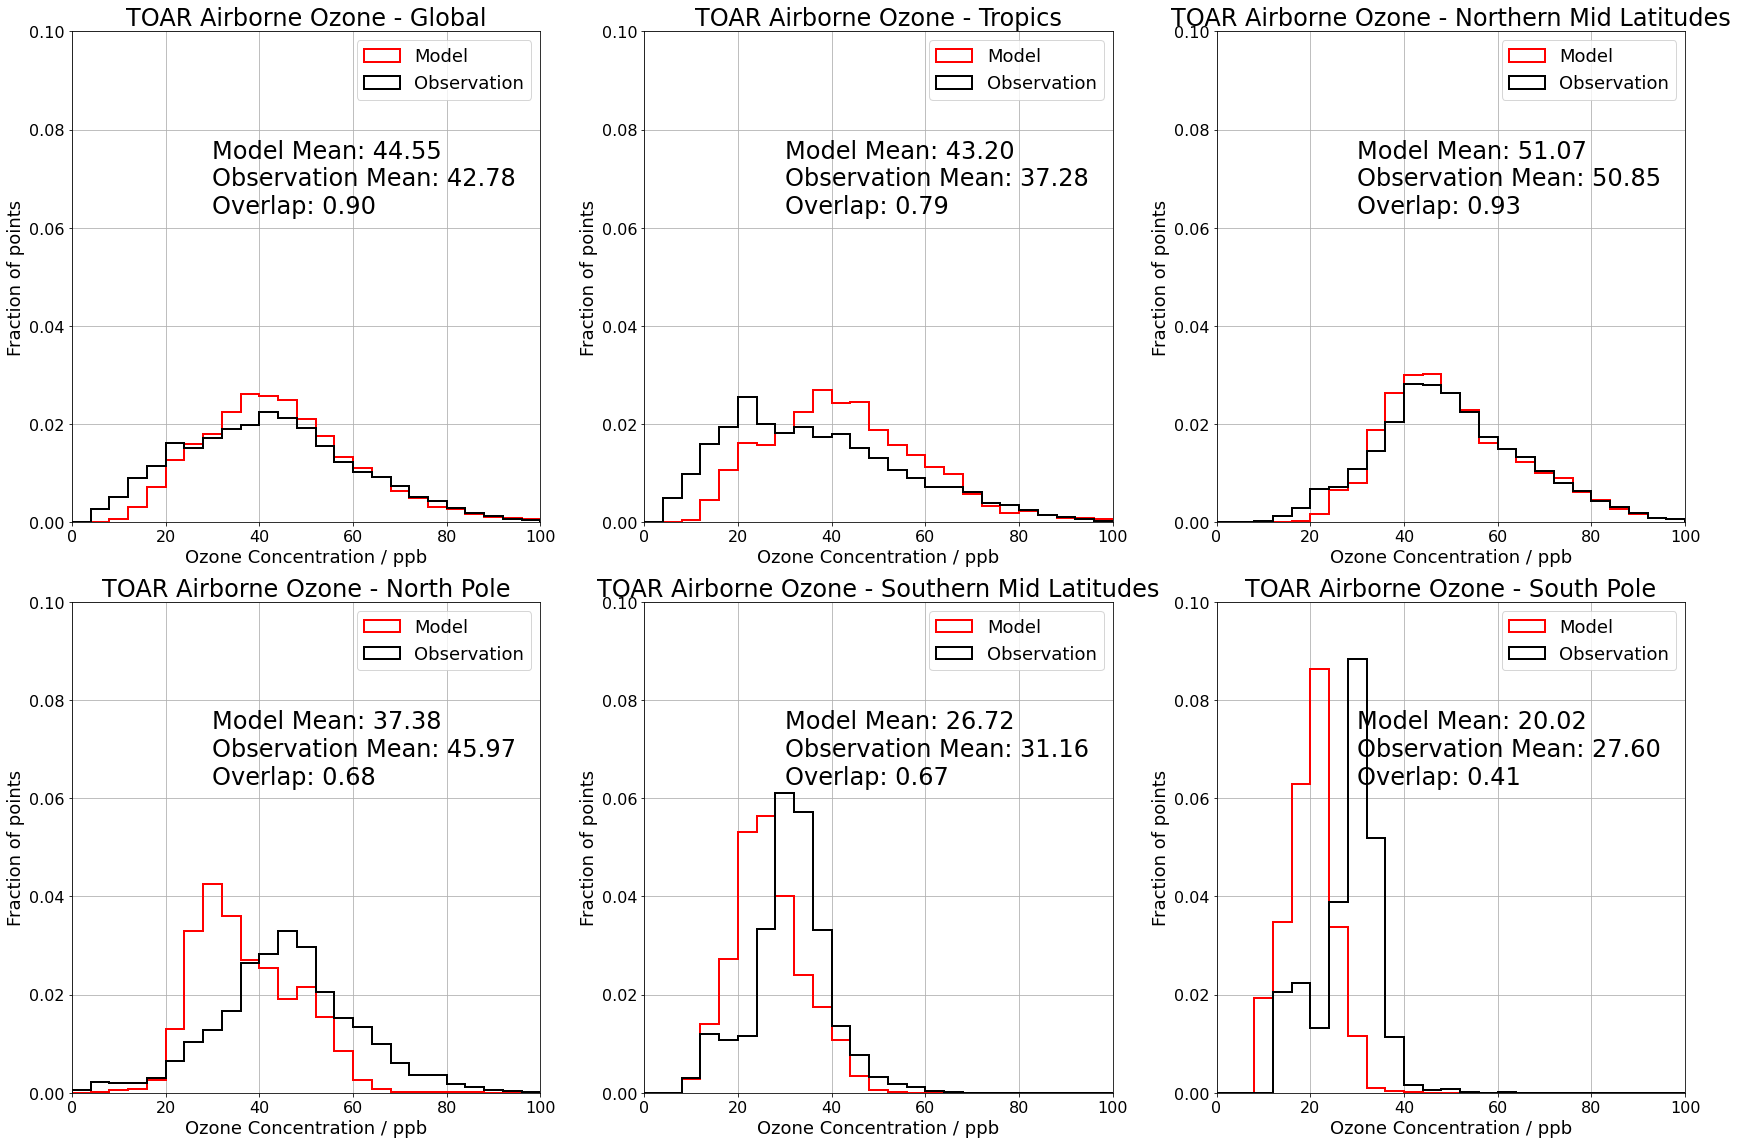

In [7]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Define latitude bands with an additional 'Global' category
latitude_bands = {
    'Global': None,
    'Tropics': (-30, 30),
    'Northern Mid Latitudes': (30, 60),
    'North Pole': (60, 90),
    'Southern Mid Latitudes': (-60, -30),
    'South Pole': (-90, -60)
}

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten the axes array

# Iterate over each latitude band and its corresponding axis
for (band, lat_range), ax in zip(latitude_bands.items(), axes):
    if lat_range:  # Check if lat_range is not None
        lat_start, lat_end = lat_range
        # Filter data for the current latitude band
        band_data = merge_df[(merge_df['latitude'] >= lat_start) & (merge_df['latitude'] < lat_end)]
    else:
        # Use all data for the 'Global' category
        band_data = merge_df

    # Extract ozone data
    model_ozone = band_data['mod_ozone']
    flight_ozone = band_data['obs_ozone']

    # Define histogram bins and range
    binsize = 4
    binstart = 0
    binend = 100

    # Calculate mean for each dataset
    mean_model = np.mean(model_ozone)
    mean_flight = np.mean(flight_ozone)

    # Calculate degree of overlap
    overlap = np.sum(np.minimum(np.histogram(model_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0],
                                np.histogram(flight_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0])) / len(model_ozone)

    # Plot histograms on the current axis 'ax' instead of using plt directly
    ax.hist(model_ozone, bins=np.arange(binstart, binend + binsize, binsize),
            density=True, histtype='step', facecolor='red', edgecolor='red',
            linewidth=2, label="Model")

    ax.hist(flight_ozone, bins=np.arange(binstart, binend + binsize, binsize),
             density=True, histtype='step', facecolor='None', edgecolor='black',
             linewidth=2, label="Observation")

    # Customize the subplot
    ax.set_xlabel('Ozone Concentration / ppb', fontsize=18)
    ax.set_ylabel('Fraction of points', fontsize=18)
    ax.set_title(f'TOAR Airborne Ozone - {band}', fontsize=24)
    ax.set_xlim(0, 100) 
    ax.set_ylim(0, 0.1)
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16) 

    # Add mean and overlap information in the middle right of each subplot
    info_text = f'Model Mean: {mean_model:.2f}\nObservation Mean: {mean_flight:.2f}\nOverlap: {overlap:.2f}'
    ax.text(0.3, 0.7, info_text, transform=ax.transAxes, fontsize=24, va='center', ha='left')

# Adjust layout
plt.tight_layout()

# Save the entire figure to a file
save_path = os.path.join(save_dir, '6_flight_histograms.png')
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the figure
plt.show()

# Close the figure
plt.close(fig)

Split the data into Tropics regional dataframes

In [8]:
# Define the longitude bands
longitude_bands = {
    'T1': (180, 290),
    'T3': (30, 110),
    'T4': (110, 180),
}

# T2 is a special case with two ranges
T2_ranges = [(290, 360), (0, 30)]

# Filter data for latitude between -30 and 30
tropics_df = merge_df[(merge_df['latitude'] >= -30) & (merge_df['latitude'] <= 30)]

# Create a dictionary to hold the dataframes
dfs = {}

# Create the T1, T3, and T4 dataframes based on longitude bands
for band, (long_start, long_end) in longitude_bands.items():
    dfs[band] = tropics_df[(tropics_df['longitude'] >= long_start) & (tropics_df['longitude'] <= long_end)]

# Handle T2 separately due to its non-continuous nature
T2_df_1 = tropics_df[(tropics_df['longitude'] >= T2_ranges[0][0]) & (tropics_df['longitude'] <= T2_ranges[0][1])]
T2_df_2 = tropics_df[(tropics_df['longitude'] >= T2_ranges[1][0]) & (tropics_df['longitude'] <= T2_ranges[1][1])]
dfs['T2'] = pd.concat([T2_df_1, T2_df_2])

# Assign the dataframes to individual variables
T1, T2, T3, T4 = dfs['T1'], dfs['T2'], dfs['T3'], dfs['T4']

# Create a list of the dataframes for iteration
regional_dataframes = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4}

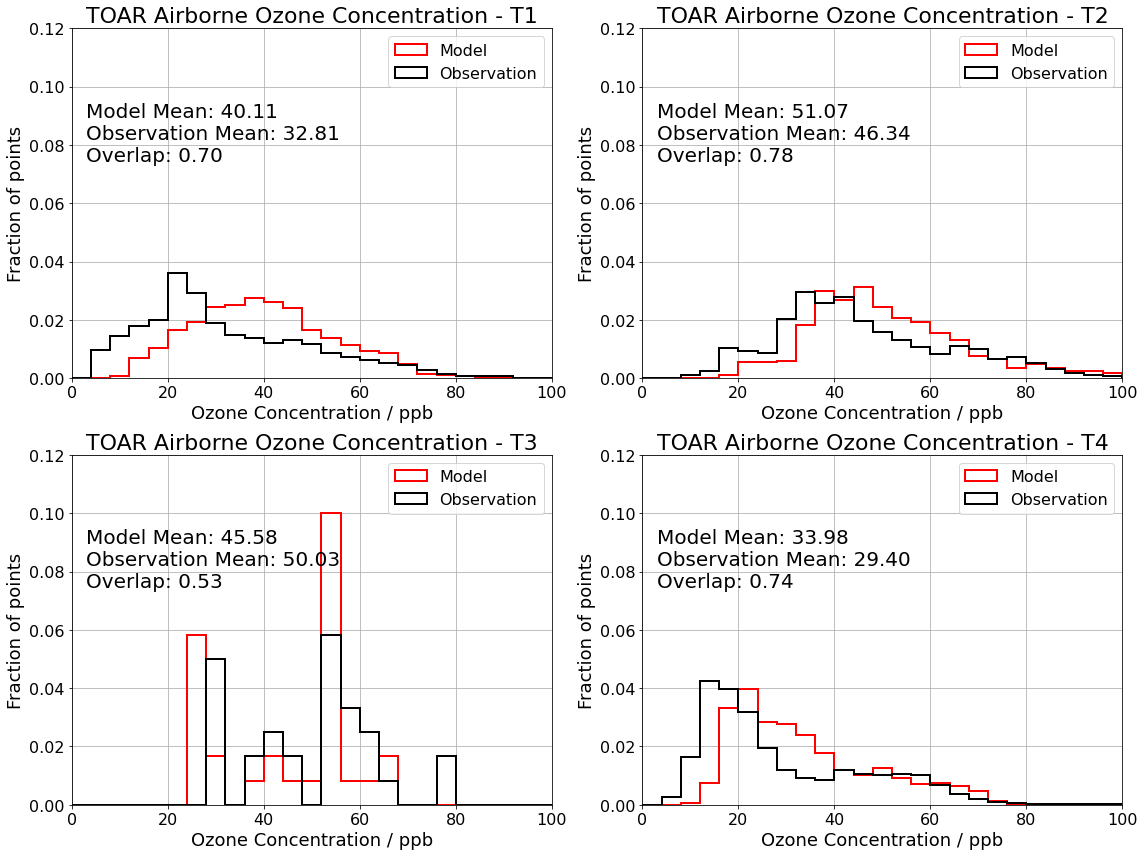

In [9]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))  # Adjust figure size as needed
axes = axes.flatten()

# Iterate over each dataframe and its corresponding axis
for (band, band_data), ax in zip(regional_dataframes.items(), axes):
    # Extract ozone data
    model_ozone = band_data['mod_ozone']
    flight_ozone = band_data['obs_ozone']

    # Define histogram bins and range
    binsize = 4
    binstart = 0
    binend = 100

    # Calculate mean for each dataset
    mean_model = np.mean(model_ozone)
    mean_flight = np.mean(flight_ozone)

    # Calculate degree of overlap
    overlap = np.sum(np.minimum(np.histogram(model_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0],
                                np.histogram(flight_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0])) / len(model_ozone)

    # Plot histograms on the current axis 'ax' instead of using plt directly
    ax.hist(model_ozone, bins=np.arange(binstart, binend + binsize, binsize),
            density=True, histtype='step', facecolor='red', edgecolor='red',
            linewidth=2, label="Model")

    ax.hist(flight_ozone, bins=np.arange(binstart, binend + binsize, binsize),
            density=True, histtype='step', facecolor='None', edgecolor='black',
            linewidth=2, label="Observation")

    # Customize the subplot
    ax.set_xlabel('Ozone Concentration / ppb', fontsize=18)
    ax.set_ylabel('Fraction of points', fontsize=18)
    ax.set_title(f'TOAR Airborne Ozone Concentration - {band}', fontsize=22)
    ax.set_xlim(0, 100) 
    ax.set_ylim(0, 0.12)  
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16) 

    # Add mean and overlap information in the middle right of each subplot
    info_text = f'Model Mean: {mean_model:.2f}\nObservation Mean: {mean_flight:.2f}\nOverlap: {overlap:.2f}'
    ax.text(0.03, 0.7, info_text, transform=ax.transAxes, fontsize=20, va='center', ha='left')

# Adjust layout
plt.tight_layout()

# Save the entire figure to a file
save_path = os.path.join(save_dir, 'regional_airborne_ozone_histograms.png')
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the figure
plt.show()

# Close the figure
plt.close(fig)

Tropics regions broken down by season

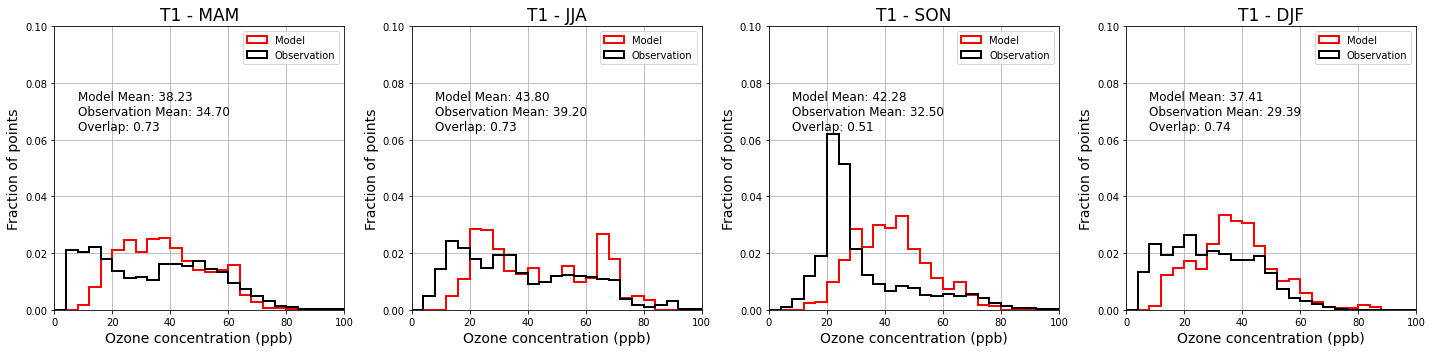

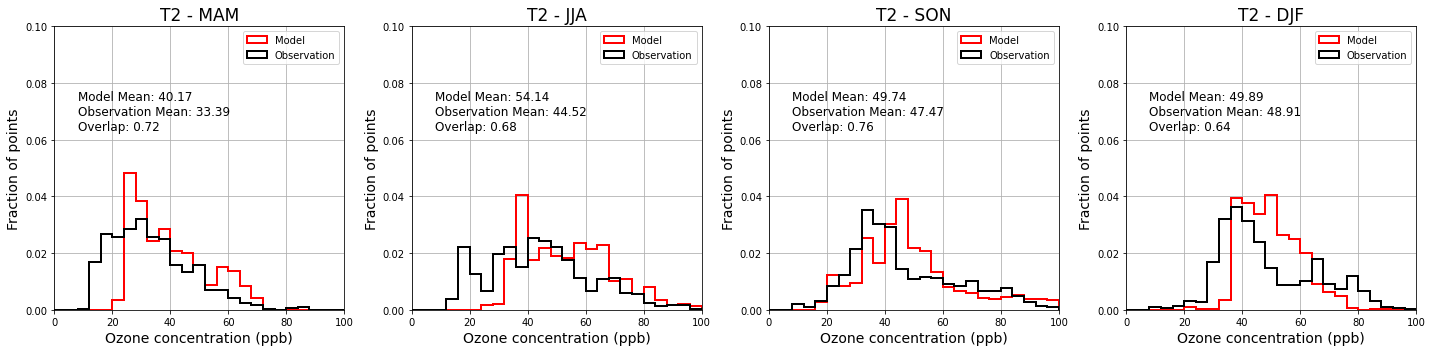

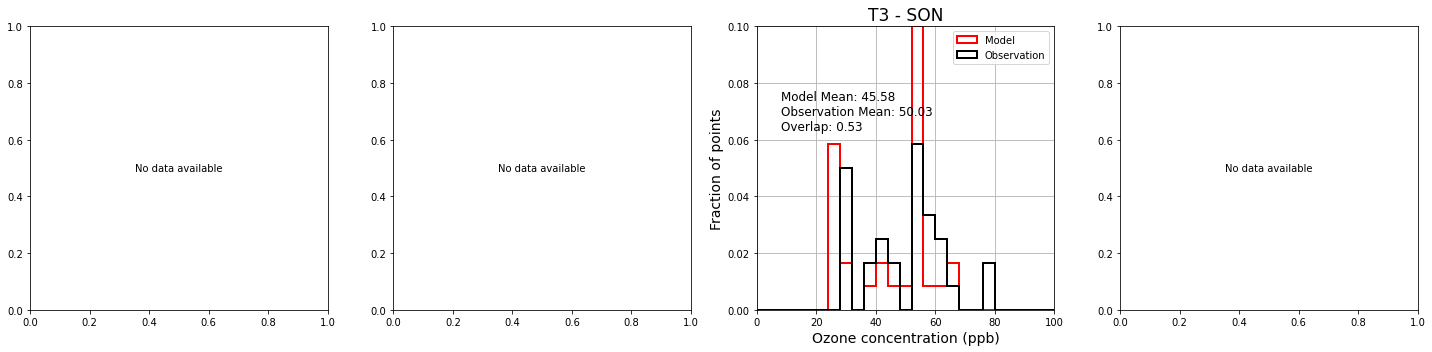

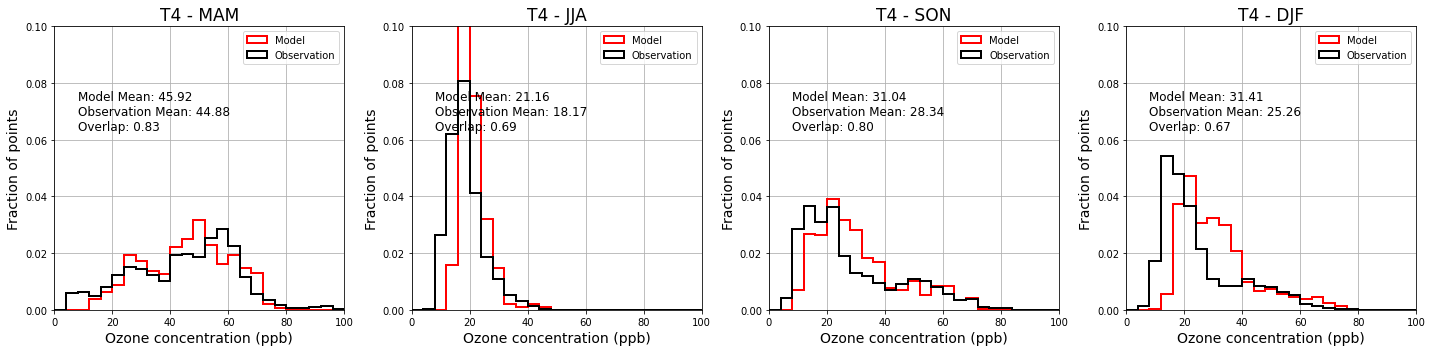

In [10]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Define seasons
seasons = {
    'MAM': (3, 5),   # March, April, May
    'JJA': (6, 8),   # June, July, August
    'SON': (9, 11),  # September, October, November
    'DJF': (12, 2)   # December, January, February
}

# Iterate over each dataframe
for band, band_df in regional_dataframes.items():
    # Create a figure for the seasons in this longitude band
    fig, axes = plt.subplots(nrows=1, ncols=len(seasons), figsize=(20, 5))  # Adjust figure size as needed
    axes = axes.flatten()

    # Iterate over each season
    for j, (season, month_range) in enumerate(seasons.items()):
        ax = axes[j]

        start_month, end_month = month_range

        # Filter data for the current season
        if start_month <= end_month:
            band_season_data = band_df[
                (band_df['datetime'].dt.month >= start_month) & (band_df['datetime'].dt.month <= end_month)
            ]
        else:
            # Handle cyclical months
            band_season_data = band_df[
                (band_df['datetime'].dt.month >= start_month) | (band_df['datetime'].dt.month <= end_month)
            ]

        # Extract ozone data
        model_ozone = band_season_data['mod_ozone'].dropna()
        obs_ozone = band_season_data['obs_ozone'].dropna()

        # Skip plotting if there are no valid data points
        if model_ozone.empty and obs_ozone.empty:
            ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            continue

        # Define histogram bins and range
        binsize = 4
        binstart = 0
        binend = 100

        # Calculate mean for each dataset
        mean_model = np.mean(model_ozone)
        mean_obs = np.mean(obs_ozone)

        # Calculate degree of overlap
        overlap = np.sum(np.minimum(np.histogram(model_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0],
                                    np.histogram(obs_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0])) / len(model_ozone)

        # Plot histograms on the current axis
        ax.hist(model_ozone, bins=np.arange(binstart, binend + binsize, binsize),
                density=True, histtype='step', facecolor='red', edgecolor='red',
                linewidth=2, label="Model")
        ax.hist(obs_ozone, bins=np.arange(binstart, binend + binsize, binsize),
                density=True, histtype='step', facecolor='None', edgecolor='black',
                linewidth=2, label="Observation")

        # Customize the subplot
        ax.set_xlabel('Ozone concentration (ppb)', fontsize=14)
        ax.set_ylabel('Fraction of points', fontsize=14)
        ax.set_title(f'{band} - {season}', fontsize=17)
        ax.set_xlim(0, 100)  # Adjust xlim as needed
        ax.set_ylim(0, 0.1)  # Adjust ylim as needed
        ax.grid(True)
        ax.legend(loc='upper right')

        # Add mean and overlap information in the middle right of each subplot
        info_text = f'Model Mean: {mean_model:.2f}\nObservation Mean: {mean_obs:.2f}\nOverlap: {overlap:.2f}'
        ax.text(0.08, 0.7, info_text, transform=ax.transAxes, fontsize=12, va='center', ha='left')

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

    # Close the figure
    plt.close(fig)

Tropics regions vertical profiles

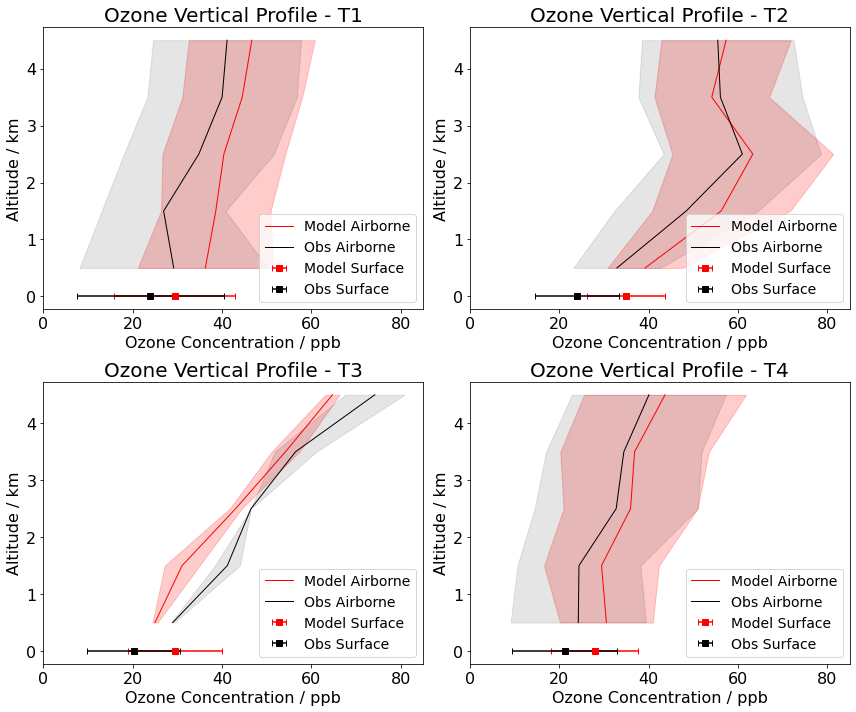

Differences for T1:
0 - 1 km: -7.08 ppb
1 - 2 km: -11.68 ppb
2 - 3 km: -5.61 ppb
3 - 4 km: -4.51 ppb
4 - 5 km: -5.54 ppb
Differences for T2:
0 - 1 km: -6.31 ppb
1 - 2 km: -7.83 ppb
2 - 3 km: -2.35 ppb
3 - 4 km: 1.93 ppb
4 - 5 km: -1.86 ppb
Differences for T3:
0 - 1 km: 3.98 ppb
1 - 2 km: 10.12 ppb
2 - 3 km: 3.44 ppb
3 - 4 km: 2.25 ppb
4 - 5 km: 9.48 ppb
Differences for T4:
0 - 1 km: -6.30 ppb
1 - 2 km: -5.05 ppb
2 - 3 km: -3.22 ppb
3 - 4 km: -2.41 ppb
4 - 5 km: -3.60 ppb


In [11]:
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Define surface ozone values from surface plot code
obs_altitude_0_data = [23.90, 24.02, 20.26, 21.17]
mod_altitude_0_data = [29.43, 34.89, 29.50, 27.91]
obs_0_std = [16.47, 9.37, 10.41, 11.75]
mod_0_std = [13.57, 8.79, 10.53, 9.77]

# Create a figure for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Convert altitude bins and midpoints to kilometers
max_altitude_km = max(df['altitude'].max() for df in regional_dataframes.values()) / 1000
altitude_bins_km = np.arange(0, max_altitude_km + 1, 1)  # Altitude bins in km
altitude_midpoints_km = [(altitude_bins_km[i] + altitude_bins_km[i+1])/2 for i in range(len(altitude_bins_km)-1)]

# Initialize a dictionary to store differences for each band
differences = {}

# Iterate over each dataframe and its corresponding axis
for band, df in regional_dataframes.items():
    ax = axes[list(regional_dataframes.keys()).index(band)]

    # Calculate means and standard deviations for each altitude bin
    mod_means = []
    mod_stds = []
    obs_means = []
    obs_stds = []
    for i in range(len(altitude_bins_km) - 1):
        bin_df = df[(df['altitude']/1000 >= altitude_bins_km[i]) & (df['altitude']/1000 < altitude_bins_km[i+1])]
        mod_means.append(bin_df['mod_ozone'].mean())
        mod_stds.append(bin_df['mod_ozone'].std())
        obs_means.append(bin_df['obs_ozone'].mean())
        obs_stds.append(bin_df['obs_ozone'].std())

    # Convert altitude midpoints to kilometers for plotting
    ax.plot(mod_means, altitude_midpoints_km, color='red', linestyle='-', label='Model Airborne', linewidth=1)
    ax.plot(obs_means, altitude_midpoints_km, color='black', linestyle='-', label='Obs Airborne', linewidth=1)

    # Fill between the standard deviations
    ax.fill_betweenx(altitude_midpoints_km, np.subtract(mod_means, mod_stds), np.add(mod_means, mod_stds), color='red', alpha=0.2)
    ax.fill_betweenx(altitude_midpoints_km, np.subtract(obs_means, obs_stds), np.add(obs_means, obs_stds), color='black', alpha=0.1)

    # Plot additional points at altitude = 0 with error bars
    ax.errorbar(mod_altitude_0_data[list(regional_dataframes.keys()).index(band)], 0, 
                xerr=mod_0_std[list(regional_dataframes.keys()).index(band)], fmt='s', color='red', label='Model Surface', capsize=3)
    ax.errorbar(obs_altitude_0_data[list(regional_dataframes.keys()).index(band)], 0, 
                xerr=obs_0_std[list(regional_dataframes.keys()).index(band)], fmt='s', color='black', label='Obs Surface', capsize=3)

    # Set labels and title for each subplot
    ax.set_xlabel('Ozone Concentration / ppb', fontsize=16)
    ax.set_ylabel('Altitude / km', fontsize=16)
    ax.set_title(f'Ozone Vertical Profile - {band}', fontsize=20)

    # Standardize axes and format
    ax.set_xlim(0, 85)
    ax.legend(loc='lower right', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Calculate and store the difference
    differences[band] = np.array(obs_means) - np.array(mod_means)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'ozone_vertical_profile_km.png'), dpi=600, bbox_inches='tight')
plt.show()

# Print the differences for each band
for band, difference in differences.items():
    print(f"Differences for {band}:")
    for i, diff in enumerate(difference):
        altitude_range = f"{i} - {i + 1} km"
        print(f"{altitude_range}: {diff:.2f} ppb")


Observation monthly average time series of observation data

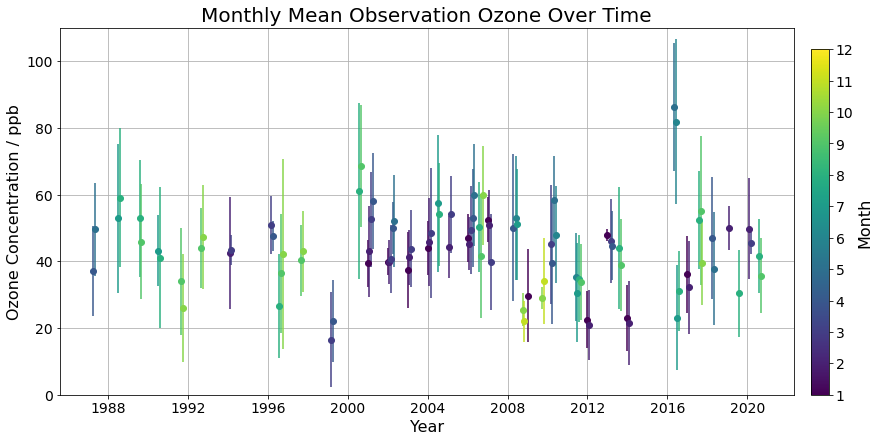

In [14]:
# Create a new DataFrame for processing
monthly_ozone_stats = obs_flight.copy()

# Convert 'time' from days since 1900 to datetime
monthly_ozone_stats['datetime'] = pd.to_datetime(monthly_ozone_stats['time'], unit='D', origin='1900-01-01')

# Extract year and month from 'datetime'
monthly_ozone_stats['year'] = monthly_ozone_stats['datetime'].dt.year
monthly_ozone_stats['month'] = monthly_ozone_stats['datetime'].dt.month

# Group by year and month and calculate mean and standard deviation for ozone
monthly_ozone_stats = monthly_ozone_stats.groupby(['year', 'month'])['ozone'].agg(['mean', 'std']).reset_index()

# Create a new 'Date' column for plotting
monthly_ozone_stats['Date'] = pd.to_datetime(monthly_ozone_stats[['year', 'month']].assign(DAY=1))

# Sort the DataFrame by 'Date'
monthly_ozone_stats = monthly_ozone_stats.sort_values(by='Date')

# Define a color map for the months
month_colors = plt.cm.viridis(np.linspace(0, 1, 12))

# Plotting with applied formatting
plt.figure(figsize=(12, 6))
for i, month in enumerate(month_colors):
    # Select data for the month
    monthly_data = monthly_ozone_stats[monthly_ozone_stats['month'] == i+1]
    
    # Plot with error bars
    plt.errorbar(monthly_data['Date'], monthly_data['mean'], yerr=monthly_data['std'], fmt='o', color=month, label=f'Month {i+1}')
    
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Monthly Mean Observation Ozone Over Time', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', labelsize=14)
plt.ylim(0, 110)

# Create a separate axis for the colorbar
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # Position: [left, bottom, width, height]

# Add colorbar for the months
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=1, vmax=12))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(1, 12, 12), label='Month')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Month', fontsize=16)

# Use subplots_adjust instead of tight_layout to avoid compatibility issues with the colorbar
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.1)

plt.savefig('/home/ajp255/nethome/Data/TrendPlots/flight_monthly_timeseries.png', dpi=600, bbox_inches='tight')

plt.show()
plt.close()


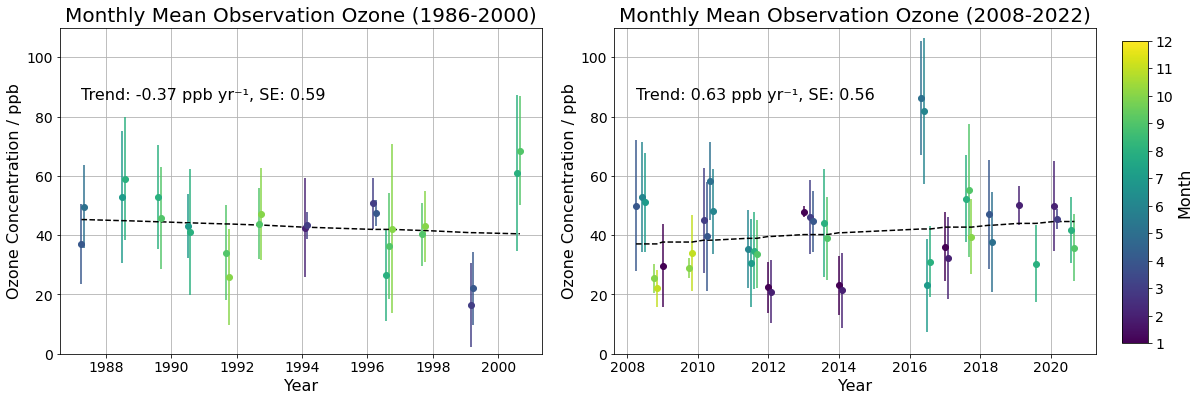

In [13]:
monthly_ozone_stats = obs_flight.copy()

# Convert 'time' from days since 1900 to datetime
monthly_ozone_stats['datetime'] = pd.to_datetime(monthly_ozone_stats['time'], unit='D', origin='1900-01-01')

# Extract year and month from 'datetime'
monthly_ozone_stats['year'] = monthly_ozone_stats['datetime'].dt.year
monthly_ozone_stats['month'] = monthly_ozone_stats['datetime'].dt.month

# Group by year and month and calculate mean and standard deviation for ozone
monthly_ozone_stats = monthly_ozone_stats.groupby(['year', 'month'])['ozone'].agg(['mean', 'std']).reset_index()

# Create a new 'Date' column for plotting
monthly_ozone_stats['Date'] = pd.to_datetime(monthly_ozone_stats[['year', 'month']].assign(DAY=1))

# Sort the DataFrame by 'Date'
monthly_ozone_stats = monthly_ozone_stats.sort_values(by='Date')

# Define a color map for the months
month_colors = plt.cm.viridis(np.linspace(0, 1, 12))

# Plotting with formatting applied
plt.figure(figsize=(18, 6))

# Calculate and plot trendlines for each period
def plot_period(period, subplot_index, title):
    plt.subplot(1, 2, subplot_index)
    for i, month in enumerate(month_colors):
        monthly_data = period[period['month'] == i+1]
        plt.errorbar(monthly_data['Date'], monthly_data['mean'], yerr=monthly_data['std'], fmt='o', color=month, label=calendar.month_abbr[i+1] if subplot_index == 1 else None)

    x_values = period['Date'].dt.year
    y_values = period['mean']
    slope, intercept, _, _, std_err = linregress(x_values, y_values)
    trendline = slope * x_values + intercept
    plt.plot(period['Date'], trendline, color='black', linestyle='--')
    plt.text(period['Date'].min(), 90, f'Trend: {slope:.2f} ppb yr⁻¹, SE: {std_err:.2f}', ha='left', va='top', fontsize=16)

    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Ozone Concentration / ppb', fontsize=16)
    plt.title(title, fontsize=20)
    plt.grid(True)
    plt.ylim(0, 110)
    plt.tick_params(axis='both', labelsize=14)

# Plot for the period 1986-2000
plot_period(monthly_ozone_stats[(monthly_ozone_stats['year'] >= 1986) & (monthly_ozone_stats['year'] <= 2000)], 1, 'Monthly Mean Observation Ozone (1986-2000)')

# Plot for the period 2008-2022
plot_period(monthly_ozone_stats[(monthly_ozone_stats['year'] >= 2008) & (monthly_ozone_stats['year'] <= 2022)], 2, 'Monthly Mean Observation Ozone (2008-2022)')

# Create colorbar on the right side of both plots
fig = plt.gcf()  # Get current figure
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=1, vmax=12))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax, ticks=np.linspace(1, 12, 12))
cbar.set_label('Month', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(wspace=0.15, left=0.05, right=0.85) 
plt.savefig('/home/ajp255/nethome/Data/TrendPlots/flight_trendlines.png', dpi=600)
plt.show()